## 什么时候需要 Cython

* 想在`Python`里达到`C语言`的速度
* 调用现有的C/C++库


## 哪些项目用了Cython

* [SageMath](http://www.sagemath.org/)
* [Pandas](https://github.com/pandas-dev/pandas/tree/master/pandas/_libs)
* [Scipy](https://github.com/scipy/scipy/tree/master/scipy)
* [scikit-learn](https://scikit-learn.org/stable/developers/performance.html#)
* [spaCy: Industrial-strength NLP](https://github.com/explosion/spaCy)
* [A pythonic python wrapper around FFTW](https://github.com/pyFFTW/pyFFTW)
* [kivy](https://kivy.org/doc/stable/installation/deps-cython.html)
* [100 Times Faster Natural Language Processing in Python](https://github.com/huggingface/100-times-faster-nlp)
* ...

一些项目的`Cython`行数(2014年统计):

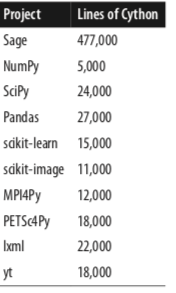

In [103]:
import sys
import cython

import numba
from numba import jit

import numpy as np

In [7]:
numba.__version__, np.__version__, cython.__version__, sys.version

('0.43.1',
 '1.16.3',
 '0.29.6',
 '3.7.3 (default, Mar 27 2019, 16:54:48) \n[Clang 4.0.1 (tags/RELEASE_401/final)]')

In [8]:
%load_ext Cython

## Cython初探

### 静态类型加速

In [9]:
def f(x):
    return x ** 2 - x


def integrate_f(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [26]:
t1 = %timeit -n5 -o integrate_f(1, 100, 10000)

2.61 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [18]:
%%cython

def f_cy1(x):
    return x ** 2 - x


def integrate_f_cy1(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_cy1(a + i * dx)
    return s * dx

In [23]:
t2 = %timeit -n5 -o integrate_f_cy1(1, 100, 10000)

1.6 ms ± 50.1 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [33]:
t1.average/t2.average

1.6322283657170238

In [43]:
%%cython

def f_cy2(double x):
    return x ** 2 - x


def integrate_f_cy2(double a, double b, int N):
    cdef double s, dx
    cdef int i
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_cy2(a + i * dx)
    return s * dx

In [44]:
t3 = %timeit -n5 -o integrate_f_cy2(1, 100, 10000)

370 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [45]:
t1.average/t3.average

7.048878956204646

In [36]:
# %%cython?

In [102]:
%%cython 

cdef double f_cy3(double x):
    return x ** 2 - x


def integrate_f_cy3(double a, double b, int N):
    cdef double s, dx
    cdef int i
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_cy3(a + i * dx)
    return s * dx

In [47]:
t4 = %timeit -n5 -o integrate_f_cy3(1, 100, 10000)

11.1 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [48]:
t1.average/t4.average

234.9922352210674

In [90]:
@jit(nopython=True, nogil=True)
def f_jit(x):
    return x ** 2 - x

@jit(nopython=True, nogil=True, fastmath=True)
def integrate_f_jit(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_jit(a + i * dx)
    return s * dx

In [91]:
integrate_f_jit(1, 100, 10000)

328284.49661716504

In [99]:
t5 = %timeit -n5 -o integrate_f_jit(1, 100, 10000)

The slowest run took 8.28 times longer than the fastest. This could mean that an intermediate result is being cached.
19.6 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [100]:
t1.best/t5.best, t1.best/t4.best

(256.2419324605358, 216.62861535363305)

### 调用C/C++库

In [53]:
from wrap_integrate import integrate_c

In [54]:
t5 = %timeit -n5 -o integrate_c(1, 100, 10000)

12.5 µs ± 331 ns per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [55]:
t1.average/t5.average

207.76058545855096

In [56]:
integrate_c(1, 100, 10000)

328284.496617165

In [58]:
integrate_f(1, 100, 10000)

328284.496617165

In [59]:
integrate_f_cy3(1, 100, 10000)

328284.496617165

## Cython 做了什么?

1. `Cython`首先将`Python`代码编译成优化的`C`语言
2. 使用`C`语言编译器,如`gcc, clang`等, 将优化的`C`程序编译成共享库

`Cython`提供了`cythonize`可以自动完成上面的过程. 首先将下面的代码保存到`integrate.pyx`中,

```python
cdef double f_cy3(double x):
    return x ** 2 - x

def integrate_f_cy3(double a, double b, int N):
    cdef double s, dx
    cdef int i
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_cy3(a + i * dx)
    return s * dx
```

将下面代码保存为`setup.py`, 

```python
from Cython.Build import cythonize
from distutils.core import setup, Extension

extensions = [
    Extension("integrate",
              ["integrate.pyx"],
              extra_compile_args = ["-O3"],
              extra_link_args=[]
              )
]
 
setup(
  name = "integrate",
  ext_modules = cythonize(extensions),
)
```

在命令行下运行:

```bash
python setup.py build_ext -i
```

## 编译器指令

`Cython`提供一系列指令([compiler directives](https://cython.readthedocs.io/en/latest/src/reference/compilation.html#compiler-directives))控制将`Cython`代码转换到`C`代码的过程, 有两种方式使用这些指令.

* 直接加在`.pyx`源代码的开头

```
# cython: embedsignature=True
# cython: boundscheck=False
# cython: wraparound=False
# cython: language_level=3
# cython: cdivision = True
# distutils: language = c++
```

* 使用修饰器

```python
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def integrate(...):
    ...
```

## 问题


* 编译通过, 但是调用时出现`Symbol not found: ...`

检查`setup.py`文件中是否包含了所有的`.c/.cpp`文件


* `Mac`中可以转换成`C`编译, 但是不能转换成`C++`编译

```
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 
10.9 [-Wdeprecated]
```

解决方法如下:

```python
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension("RNG",
                sources=["fib.pyx"],
                language="c++",
                extra_link_args=["-stdlib=libc++", "-mmacosx-version-min=10.14"]
                )

setup(name="RNG", ext_modules=cythonize(ext))
```
